# PROJECT: Bike Sharing Demand

- UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset





### Data Information

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

### Attribute Information

__Abstract:__ This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [103]:
# Importing libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error # RMSLE is used in Kaggle competition
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# EXPLORATORY DATA ANALYSIS (EDA)

In [104]:
df = pd.read_csv('train.csv')

In [105]:
# Cheacking for nulls

df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [106]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [107]:
# Splitting datetime cathegorical data

df['Date'] = pd.DatetimeIndex(df['datetime']).date
df['Hour'] = pd.DatetimeIndex(df['datetime']).hour
df['Day'] = pd.DatetimeIndex(df['datetime']).day
df['Month'] = pd.DatetimeIndex(df['datetime']).month
df['Year'] = pd.DatetimeIndex(df['datetime']).year
df['Weekday'] = pd.DatetimeIndex(df['datetime']).weekday

In [108]:
df = df.drop(['datetime'], axis=1)
df = df.drop(['Date'], axis=1)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Hour,Day,Month,Year,Weekday
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,2011,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,2011,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1,2011,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1,2011,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1,2011,5


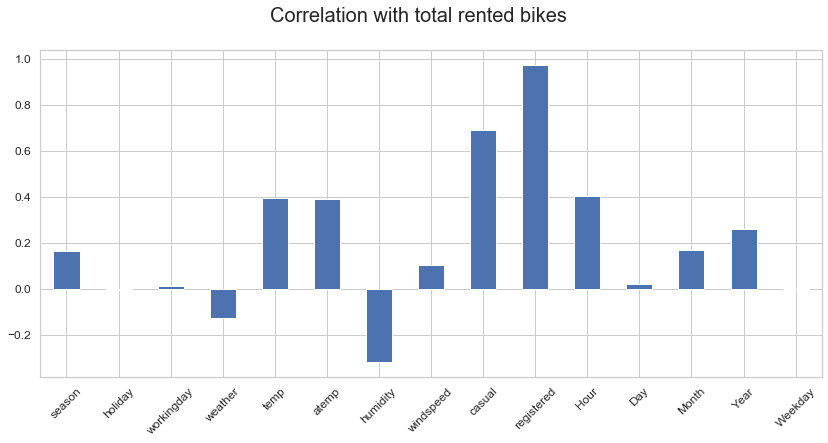

In [109]:
# Correlation between Continuous variables and Count variable

plt.suptitle('Correlation with total rented bikes', fontsize = 20)
df.drop(['count'], axis = 1).corrwith(df['count']).plot.bar(
                                            figsize = (14, 6), 
                                            fontsize = 12, rot = 45, grid = True)

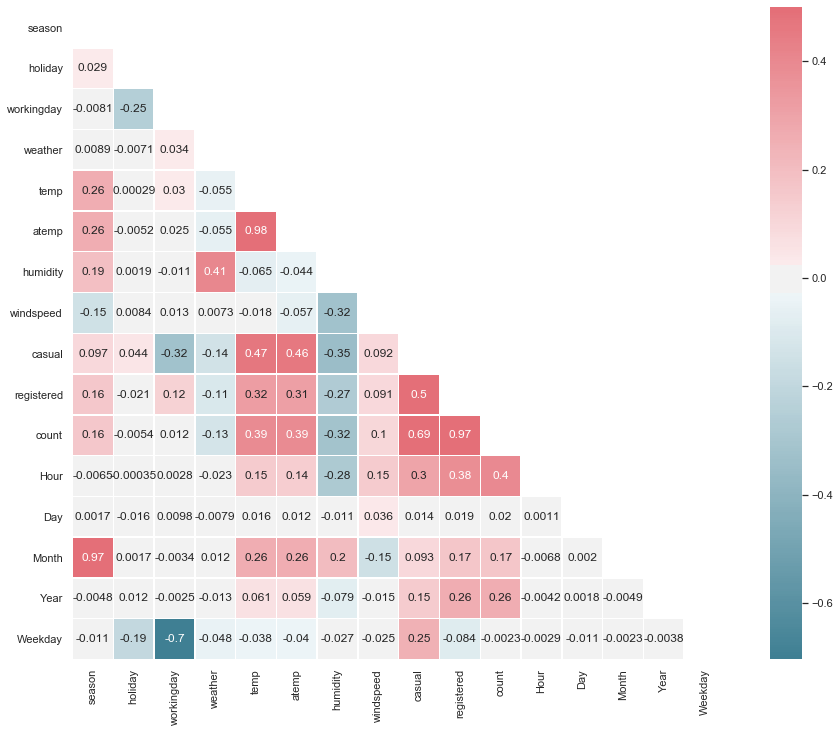

In [110]:
# Heatmap

corr = df.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
fig, axes = plt.subplots(1, 1, figsize = (16, 12))
cmap = sb.diverging_palette(220, 10, as_cmap = True)

sb.heatmap(corr, mask = mask, square=True, annot = True, linewidth = 0.5,
           ax = axes, cmap = cmap, vmax = 0.5, center = 0)

__Observations__:

- Temperature invariables are positive correlated. 'atemp' is straight linked with 'temp', nearly the same thing
- Windspeed has no significant correlation with none of the variables of interest ('casual;', 'registered' & 'count')
- 'huminity' has negative correlation with our variables of interest ('casua;', 'registered' & 'count')

### Data Visualization of Season & Weather / Variables of Interest

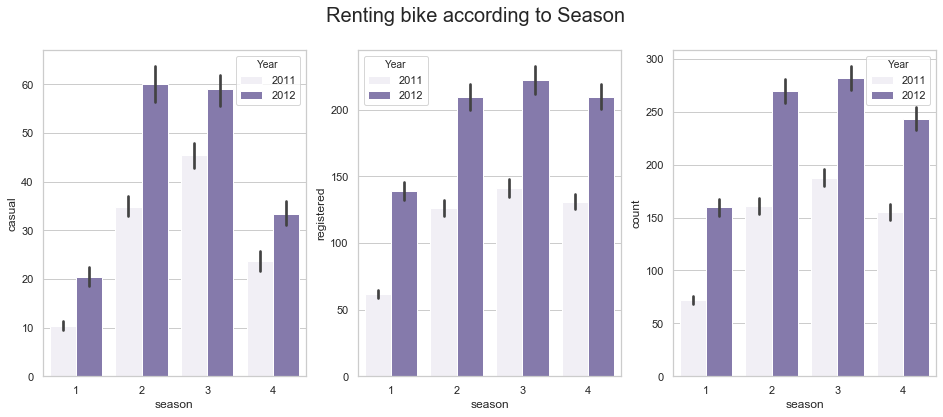

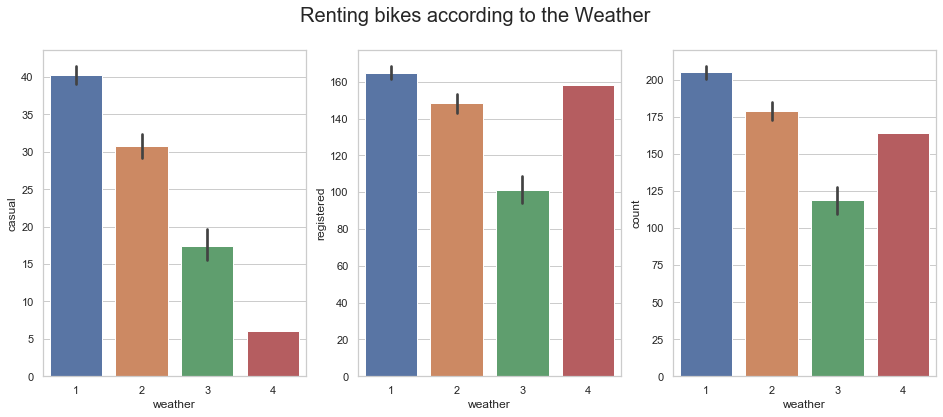

In [111]:
# Season vs Variables of interest

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(16,6)
sb.set(style = "whitegrid")
plt.suptitle('Renting bike according to Season', fontsize = 20)
sb.barplot(x = 'season', y = 'casual',     hue = 'Year', data = df, ax = ax1, color = 'm')
sb.barplot(x = 'season', y = 'registered', hue = 'Year', data = df, ax = ax2, color = 'm')
sb.barplot(x = 'season', y = 'count',      hue = 'Year', data = df, ax = ax3, color = 'm')

# Weather vs Variables of interest

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(16,6)
sb.set(style = "whitegrid")
plt.suptitle('Renting bikes according to the Weather', fontsize = 20)
sb.barplot(x = 'weather', y = 'casual',     data = df, ax = ax1)
sb.barplot(x = 'weather', y = 'registered', data = df, ax = ax2)
sb.barplot(x = 'weather', y = 'count',      data = df, ax = ax3)

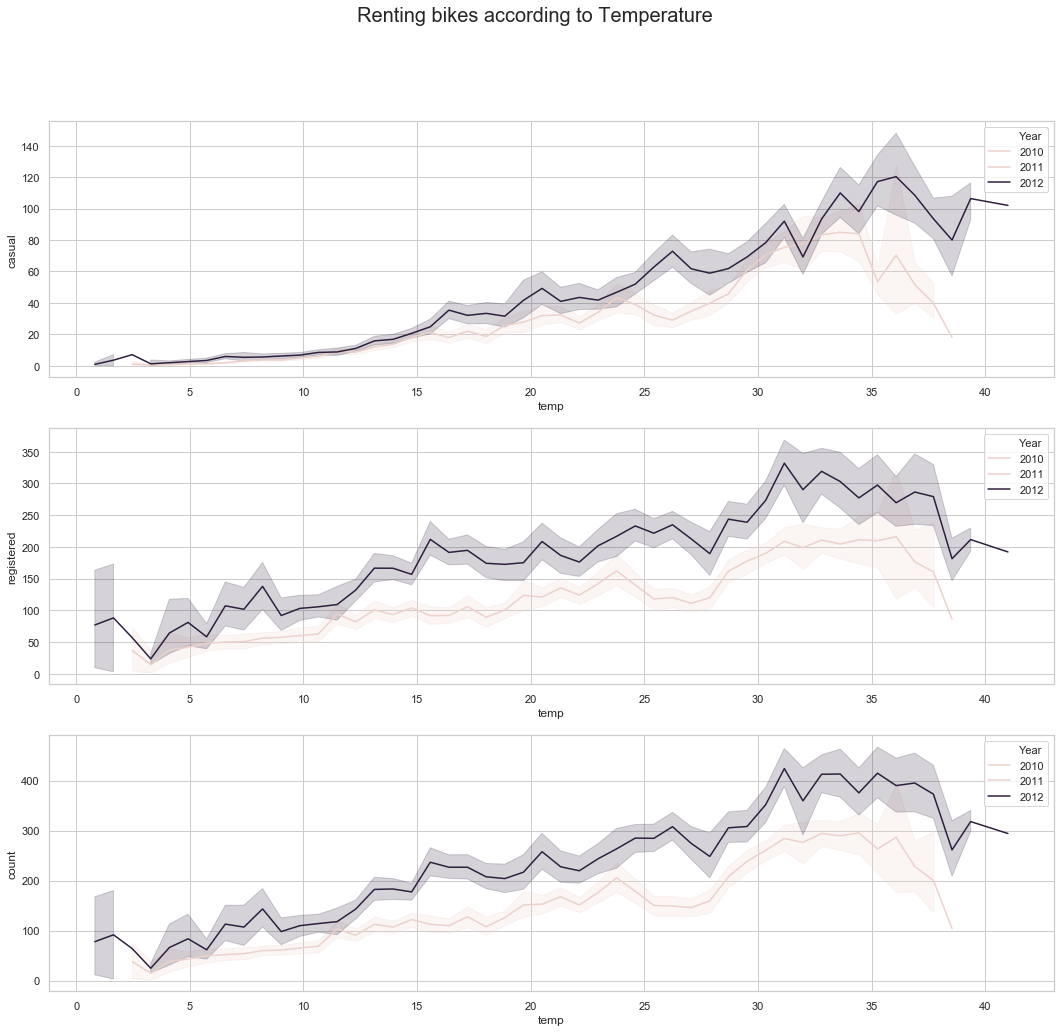

In [112]:
# TEMPERATURE X CASUAL / REGISTERED / COUNT

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3)
fig.set_size_inches(18, 16)
sb.set(style = "whitegrid")
plt.suptitle('Renting bikes according to Temperature', fontsize = 20)
sb.lineplot(x = 'temp', y = 'casual',     hue = 'Year', data = df, ax = ax1)
sb.lineplot(x = 'temp', y = 'registered', hue = 'Year', data = df, ax = ax2)
sb.lineplot(x = 'temp', y = 'count',      hue = 'Year', data = df, ax = ax3)

__Observations:__

- From the graphs above, we can observe that registered customers tend to rent bikes much more than casual customers.
- When the weather is bad (raining, storm, cold, snow, etc), casual customers are not likelly to rent bikes, while registered ones are still using bikes, a bit less than usual but still more often than casual  users.
- It could be explained because registered users might use bikes for day by day usage, like work, school etc.
- Further analysis must be made by day, month, hour and weekends.


### Data Visualization of Daytime / Variables of Interest

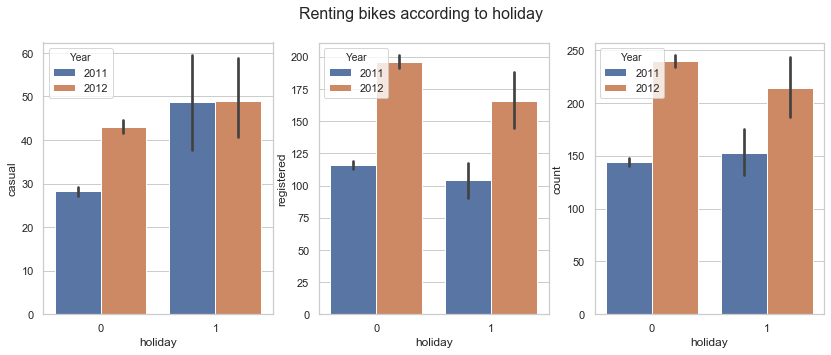

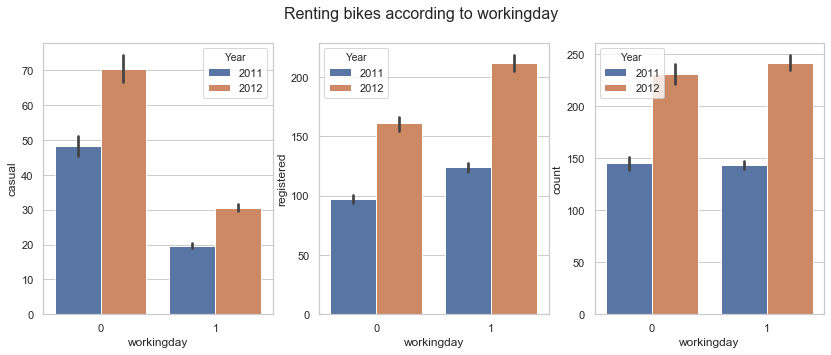

In [113]:
# HOLIDAY

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(14,5)
plt.suptitle('Renting bikes according to holiday', fontsize = 16)
sb.barplot(x = 'holiday', y = 'casual',     hue = 'Year', data = df, ax = ax1)
sb.barplot(x = 'holiday', y = 'registered', hue = 'Year', data = df, ax = ax2)
sb.barplot(x = 'holiday', y = 'count',      hue = 'Year', data = df, ax = ax3)

# WORKINGDAY

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(14,5)
plt.suptitle('Renting bikes according to workingday', fontsize = 16)
sb.barplot(x = 'workingday', y = 'casual',     hue = 'Year', data = df, ax = ax1)
sb.barplot(x = 'workingday', y = 'registered', hue = 'Year', data = df, ax = ax2)
sb.barplot(x = 'workingday', y = 'count',      hue = 'Year', data = df, ax = ax3)

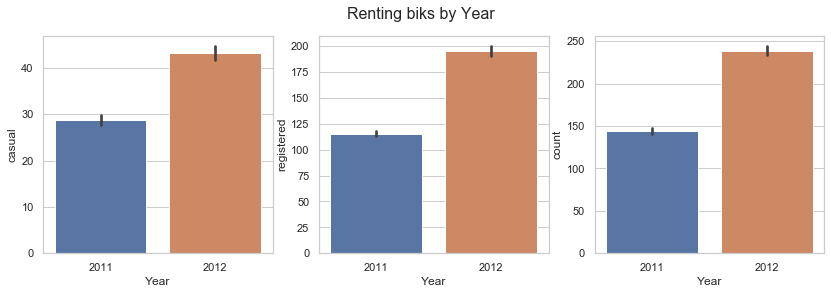

In [114]:
# YEAR

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(14,4)
plt.suptitle('Renting biks by Year', fontsize = 16)
sb.barplot(x = 'Year', y = 'casual',     data = df, ax = ax1)
sb.barplot(x = 'Year', y = 'registered', data = df, ax = ax2)
sb.barplot(x = 'Year', y = 'count',      data = df, ax = ax3)


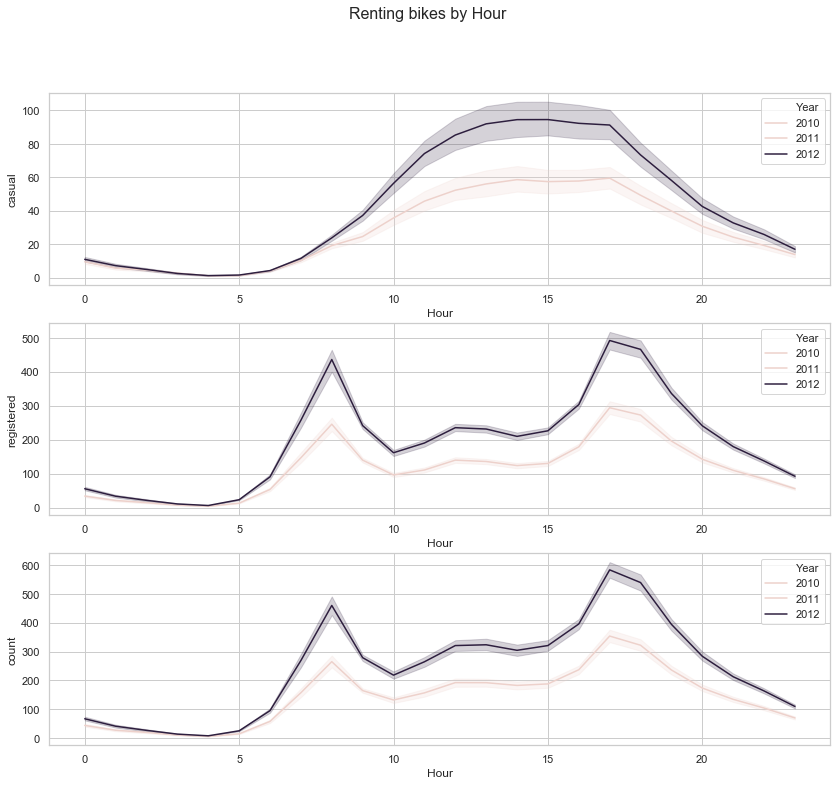

In [115]:
# HOUR

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3)
fig.set_size_inches(14,12)
sb.set(style = "whitegrid")
plt.suptitle('Renting bikes by Hour', fontsize = 16)
sb.lineplot(x = 'Hour', y = 'casual',     hue = 'Year', data = df, ax = ax1)
sb.lineplot(x = 'Hour', y = 'registered', hue = 'Year', data = df, ax = ax2)
sb.lineplot(x = 'Hour', y = 'count',      hue = 'Year', data = df, ax = ax3)

___Observatoin:__

- From the graphs above we can observe that Registered users tend to use bikes more often during working days, while casual customers are more often to use during weekends and holidays.
- In addition to that, there are two peaks when registered users more use the bikes, which are in the early morning and at the end of the working day (7-8am and 17-18pm), it explicitely confirms that these are users that use the bikes for day by day usage, like going to work, going to school (basicaly working hours). Casual users are more likely to rent bikes after 15pm by the end of the day, which shows their interest in casual usage and/or leisure.
- The distribution by month is straight linked to the season distribution, which is related to the type of weather.

# FEATURE ENGINEERING

- Distribution transformations (not necessary)
- Outliers
- Selection of important features

### Checking Probability Distribution

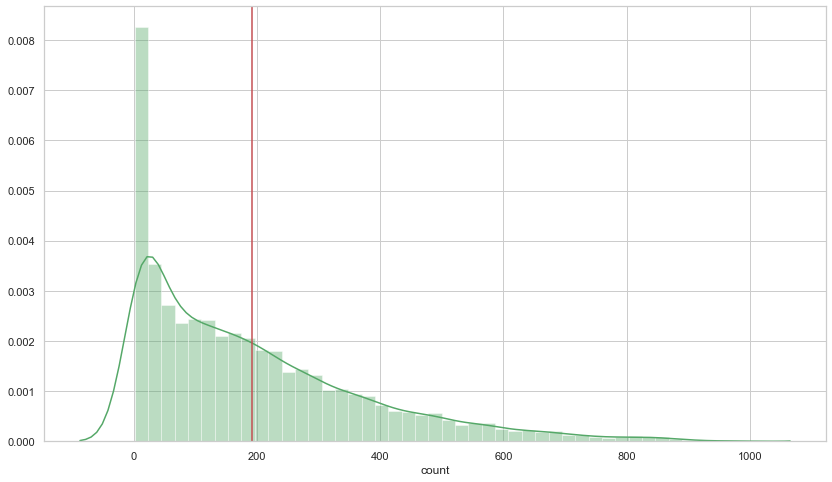

In [116]:
# Count distribution

fig = plt.figure(figsize = (14, 8))
sb.distplot(df['count'], color = 'g')
plt.axvline(df['count'].mean(), 0 , 1, color = 'r')

### Outliers

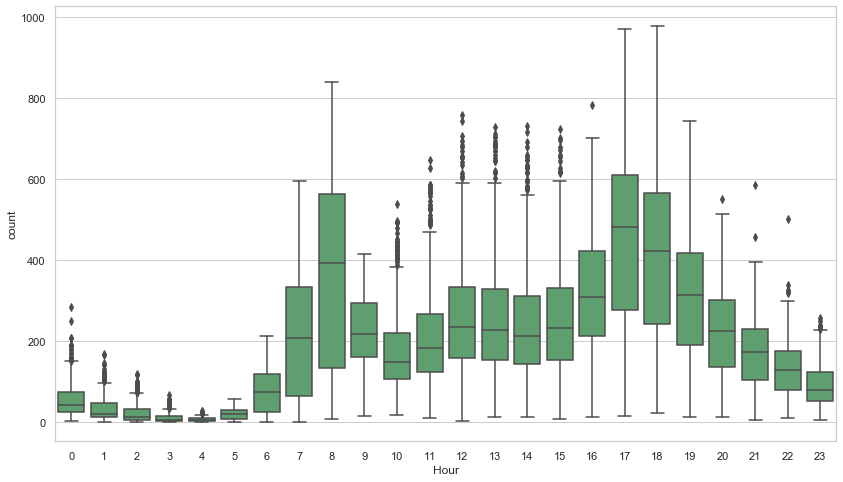

In [117]:
# Checking for outliers

fig = plt.figure(figsize = (14, 8))
sb.boxplot(x = 'Hour', y = 'count', data = df, color = 'g')   

In [118]:
# Outliers_ Applying IQR technique for reducing outliers

df_NoOut = pd.DataFrame()
a = np.arange(24)

for i in a:
    df1 = df.loc[df['Hour'] == i]
    Q1, Q3 = np.percentile(df1['count'], [25, 75])
    IQR = Q3 - Q1
    df2 = df1.loc[~((df1['count'] < (Q1 - 1.5 * IQR)) | (df1['count'] > (Q3 + 1.5 * IQR)))]
    df_NoOut = pd.concat([df_NoOut, df2])
    i = i + 1

df = df_NoOut

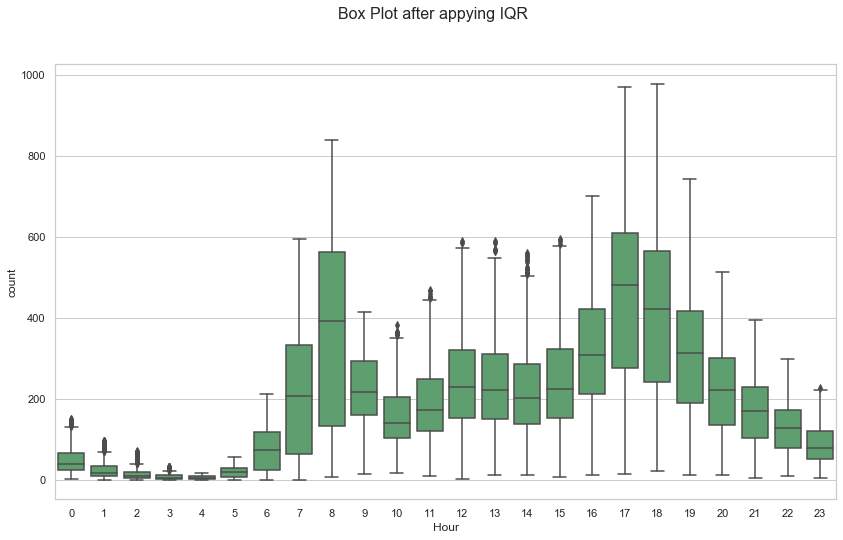

In [119]:
# BOXPLOT of count distribution after applying IQR (Inter Quartile Range)

fig1 = plt.figure(figsize = (14, 8))
sb.set(style = "whitegrid")
plt.suptitle('Box Plot after appying IQR', fontsize = 16)
ax = sb.boxplot(x = 'Hour', y = 'count',   data = df, color = 'g')

### Feature selection

In [120]:
df_test = pd.read_csv('test.csv') # csv file with data from day 20 to 30th of every month

In [121]:
# Splitting datetime feature of the test file

df_test['Date'] = pd.DatetimeIndex(df_test['datetime']).date
df_test['Hour'] = pd.DatetimeIndex(df_test['datetime']).hour
df_test['Day'] = pd.DatetimeIndex(df_test['datetime']).day
df_test['Month'] = pd.DatetimeIndex(df_test['datetime']).month
df_test['Year'] = pd.DatetimeIndex(df_test['datetime']).year
df_test['count'] = np.nan

df_test = df_test.drop(['datetime'], axis=1)
df_test = df_test.drop(['Date'], axis=1)

In [122]:
# Now I am selecting the features which are going to be used in my predictive model

selected_features = ['Day', 'Hour', 'Month', 'Year', 'holiday', 'workingday', 'weather', 'temp', 'count']

df_test = df_test[selected_features]
df = df[selected_features]

In [123]:
print(df.head())
print(df_test.head())

X = df.drop(['count'], axis = 1)
y = df['count']

    Day  Hour  Month  Year  holiday  workingday  weather   temp  count
0     1     0      1  2011        0           0        1   9.84     16
24    2     0      1  2011        0           0        2  18.86     17
47    3     0      1  2011        0           1        1   9.02      5
69    4     0      1  2011        0           1        1   6.56      5
92    5     0      1  2011        0           1        1   8.20      6
   Day  Hour  Month  Year  holiday  workingday  weather   temp  count
0   20     0      1  2011        0           1        1  10.66    NaN
1   20     1      1  2011        0           1        1  10.66    NaN
2   20     2      1  2011        0           1        1  10.66    NaN
3   20     3      1  2011        0           1        1  10.66    NaN
4   20     4      1  2011        0           1        1  10.66    NaN


In [124]:
# Split Data

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_test = df_test.drop(['count'], axis = 1)
y_test = df_test.iloc[:, -1]

# MODEL¶
- Fitting models: Decision Tree / Random Forest / XgBoost
- Predict results
- Evaluating Results

### Regression Tree

Train: (R-Squared):  1.0
(R-Squared:):  0.8825319547482036
(MAE): 35.612994350282484
Train: RMSLE (Root Mean Squared Log Error):  0.0
RMSLE (Root Mean Squared Log Error):  0.43991184685674656


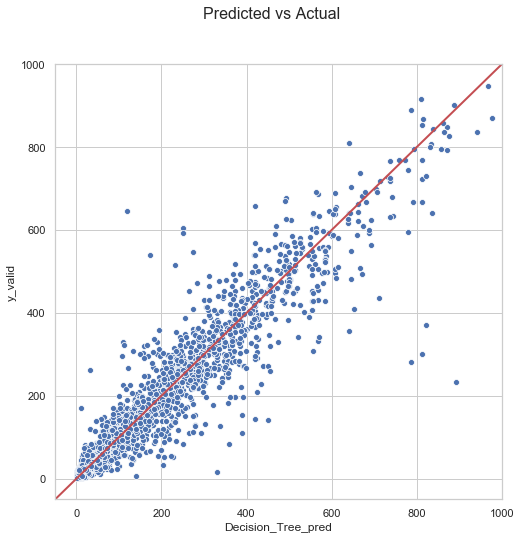

In [125]:
# DECISION TREE

regressor_DT = DecisionTreeRegressor(random_state = 0)
DT_model = regressor_DT.fit(X_train, y_train)

y_pred_DT = regressor_DT.predict(X_valid)
np.set_printoptions(precision=2)


# Scoring train and test results

print('Train: (R-Squared): ', r2_score(y_train, DT_model.predict(X_train)))
print('(R-Squared:): ', r2_score(y_valid, y_pred_DT))

print('(MAE):', mean_absolute_error(y_valid, y_pred_DT))

print('Train: RMSLE (Root Mean Squared Log Error): ', np.sqrt(mean_squared_log_error(y_train, DT_model.predict(X_train))))
print('RMSLE (Root Mean Squared Log Error): ', np.sqrt(mean_squared_log_error(y_valid, y_pred_DT)))

plt.figure(figsize = (8, 8))
sb.scatterplot(x = y_pred_DT, y = y_valid)
plt.xlim([-50, 1000])
plt.ylim([-50, 1000])
plt.plot([-50, 1000], [-50, 1000], color = 'r', linestyle = '-', linewidth = 2)
plt.suptitle('Predicted vs Actual', fontsize = 16)
plt.xlabel('Decision_Tree_pred', fontsize = 12)
plt.ylabel('y_valid', fontsize = 12)
plt.show()

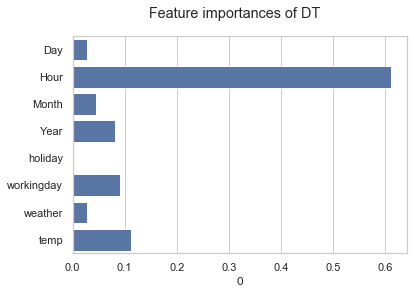

In [126]:
# Feature importance of the Decision Tree Model

DT_features = pd.DataFrame(DT_model.feature_importances_, index = ['Day', 'Hour', 'Month', 'Year',
                                                     'holiday', 'workingday', 'weather', 'temp'])

plt.suptitle('Feature importances of DT')
ax = sb.barplot(x = 0, y = ['Day', 'Hour', 'Month', 'Year', 'holiday', 'workingday', 'weather',
                            'temp'], data = DT_features, orient = 'h', color = 'b')

### Random Forest Regressor

Train: (R-Squared):  0.9838950149032389
Test: (R-Squared:):  0.9088134632660393
Test (MAE): 31.44745762711864
Test_RMSLE (Root Mean Squared Log Error): 0.37887009833120433


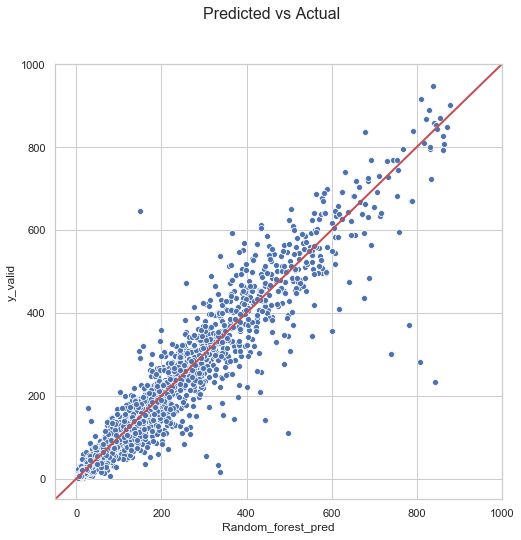

In [127]:
# RANDOM FOREST

regressor_RF = RandomForestRegressor(n_estimators = 5, random_state = 0)
RF_model = regressor_RF.fit(X_train, y_train)

y_pred_RF = regressor_RF.predict(X_valid)
np.set_printoptions(precision=2)


# Scoring train and test results

print('Train: (R-Squared): ', r2_score(y_train, RF_model.predict(X_train)))
print('Test: (R-Squared:): ', r2_score(y_valid, y_pred_RF))
print('Test (MAE):', mean_absolute_error(y_valid, y_pred_RF))
print('Test_RMSLE (Root Mean Squared Log Error):', np.sqrt(mean_squared_log_error(y_valid, y_pred_RF)))

plt.figure(figsize = (8, 8))
sb.scatterplot(x = y_pred_RF, y = y_valid)
plt.xlim([-50, 1000])
plt.ylim([-50, 1000])
plt.plot([-50, 1000], [-50, 1000], color = 'r', linestyle = '-', linewidth = 2)
plt.suptitle('Predicted vs Actual', fontsize = 16)
plt.xlabel('Random_forest_pred', fontsize = 12)
plt.ylabel('y_valid', fontsize = 12)
plt.show()

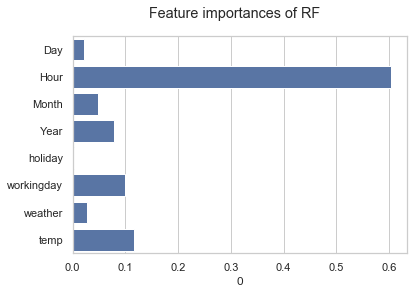

In [128]:
# Feature importance of the Decision Tree Model

RF_features = pd.DataFrame(RF_model.feature_importances_, index = ['Day', 'Hour', 'Month', 'Year',
                                                     'holiday', 'workingday', 'weather', 'temp'])

plt.suptitle('Feature importances of RF')
ax = sb.barplot(x = 0, y = ['Day', 'Hour', 'Month', 'Year', 'holiday', 'workingday', 'weather',
                            'temp'], data = RF_features, orient = 'h', color = 'b')

### XgBoost regressor

In [129]:
# XGBOOST

regressor_xgb = xgb.XGBRegressor(learning_rate = 0.2,
                                 n_estimators = 12,
                                 max_depth = 8) 
xgb_model     = regressor_xgb.fit(X_train, y_train)
y_pred_xgb    = xgb_model.predict(X_valid)


Train: (R-Squared):  0.9278997994577554
Test:  (R-Squared):  0.903184580080909
Mean Absolute error:  35.253642004425245
Train  (Root Mean Squared Log Error):  0.2957896477447487
Test   (Root Mean Squared Log Error):  0.3560684902193157


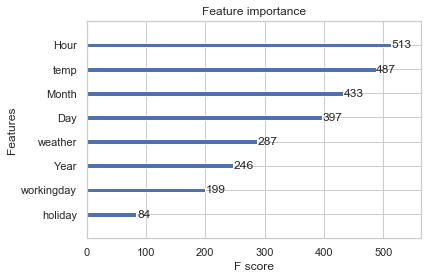

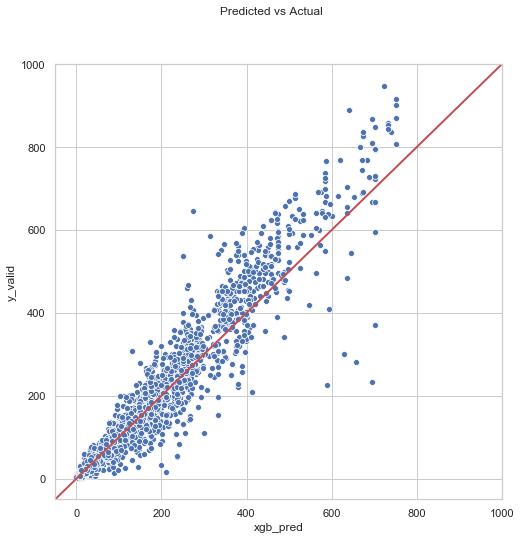

In [130]:
# Scoring train and test results
print('Train: (R-Squared): ', r2_score(y_train, xgb_model.predict(X_train)))
print('Test:  (R-Squared): ', r2_score(y_valid, y_pred_xgb))
print('Mean Absolute error: ', mean_absolute_error(y_valid, y_pred_xgb))
print('Train  (Root Mean Squared Log Error): ', np.sqrt(mean_squared_log_error(y_train, xgb_model.predict(X_train))))
print('Test   (Root Mean Squared Log Error): ', np.sqrt(mean_squared_log_error(y_valid, y_pred_xgb)))


# Feature Importance Graph
xgb.plot_importance(xgb_model)

# Predicted vs Actual values
plt.figure(figsize = (8, 8))
sb.scatterplot(x = y_pred_xgb, y = y_valid)
plt.xlim([-50, 1000])
plt.ylim([-50, 1000])
plt.plot([-50, 1000], [-50, 1000], color = 'r', linestyle = '-', linewidth = 2)
plt.suptitle('Predicted vs Actual', fontsize = 12)
plt.xlabel('xgb_pred', fontsize = 12)
plt.ylabel('y_valid', fontsize = 12)
plt.show()

__Observationa:__

- The Decision Tree model overfits, While random Forest presents better results of r2 and less overfitting.


- XgBoost Regressor model finds the best result, being train and test scores very close to each other (showing it  is a realistic model) 
- r2_score = 90% | RMSLE = 0.35 

# Results with the test dataset

- Best model has been the XgBoost

In [131]:
y_pred_FINAL = regressor_xgb.predict(X_test)

In [132]:
sample_submission = pd.read_csv('sampleSubmission.csv')

In [133]:
sample_submission['count'] = y_pred_FINAL

In [134]:
sample_submission.to_csv('Submission_Xgb.csv', index = False)

# Show analysis of predicted values

This Part is only to visualize the predicted values

In [135]:
sample_submission

,datetime,count
0,2011-01-20 00:00:00,7.429850
1,2011-01-20 01:00:00,4.530166
2,2011-01-20 02:00:00,3.317489
3,2011-01-20 03:00:00,2.314390
4,2011-01-20 04:00:00,2.314390
...,...,...
6488,2012-12-31 19:00:00,360.348145
6489,2012-12-31 20:00:00,214.159943
6490,2012-12-31 21:00:00,183.711487
6491,2012-12-31 22:00:00,111.051636


In [136]:
sample_submission['Date']  = pd.DatetimeIndex(sample_submission['datetime']).date
sample_submission['Hour']  = pd.DatetimeIndex(sample_submission['datetime']).hour
sample_submission['Day']   = pd.DatetimeIndex(sample_submission['datetime']).day
sample_submission['Month'] = pd.DatetimeIndex(sample_submission['datetime']).month
sample_submission['Year']  = pd.DatetimeIndex(sample_submission['datetime']).year

sample_submission = sample_submission.drop(['datetime'], axis=1)
sample_submission = sample_submission.drop(['Date'], axis=1)
sample_submission.head()

,count,Hour,Day,Month,Year
0,7.429850,0,20,1,2011
1,4.530166,1,20,1,2011
2,3.317489,2,20,1,2011
3,2.314390,3,20,1,2011
4,2.314390,4,20,1,2011


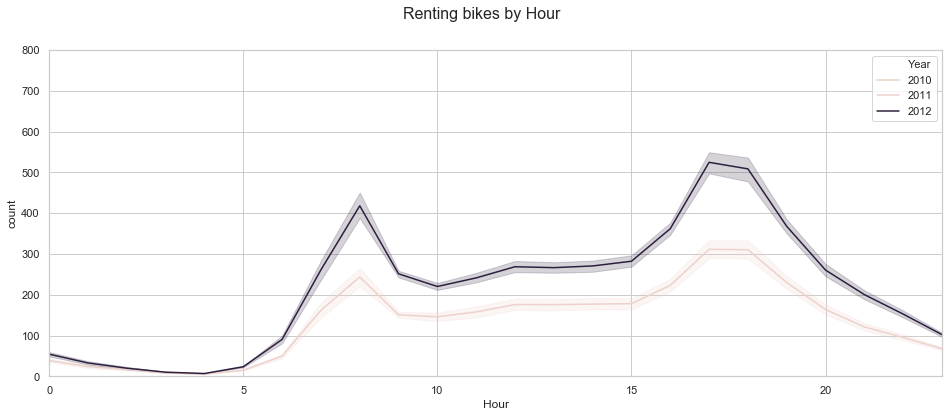

In [137]:
# HOUR

plt.figure(figsize = (16,6))
sb.set(style = "whitegrid")
plt.suptitle('Renting bikes by Hour', fontsize = 16)
plt.xlim([0, 23])
plt.ylim([0, 800])
sb.lineplot(x = 'Hour', y = 'count', hue = 'Year', data = sample_submission)

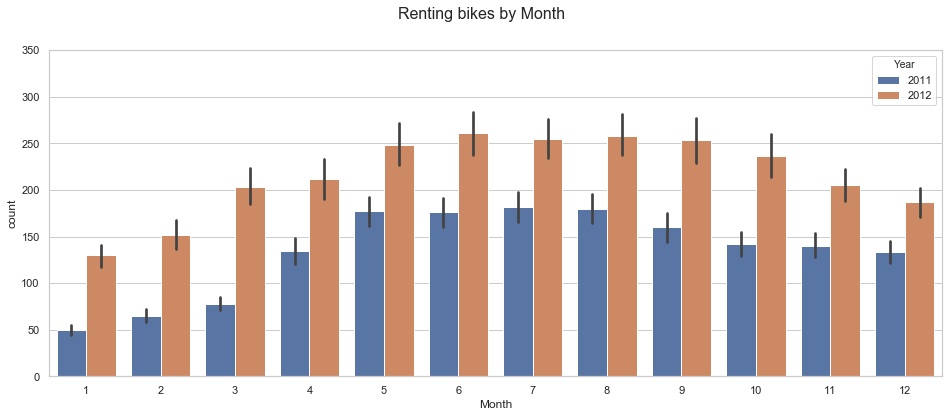

In [138]:
# MONTH

plt.figure(figsize = (16,6))
sb.set(style = "whitegrid")
plt.suptitle('Renting bikes by Month', fontsize = 16)
plt.xlim([1, 12])
plt.ylim([0, 350])
sb.barplot(x = 'Month', y = 'count', hue = 'Year', data = sample_submission)

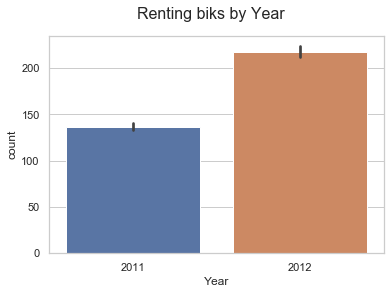

In [139]:
# YEAR

fig.set_size_inches(14,4)
plt.suptitle('Renting biks by Year', fontsize = 16)
sb.barplot(x = 'Year', y = 'count', data = sample_submission)